In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as mticker
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')

In [73]:
# --- Load cleaned dataset ---
df = pd.read_csv("cleaned_flights_data.csv", parse_dates=["FL_DATE"])
df.head()

,FL_DATE,AIRLINE,ORIGIN,DEST,DEP_DELAY,ARR_DELAY,CANCELLED,DIVERTED,DISTANCE,dep_time,...,Route,Distance_Bin,Cancelled_Carrier,Cancelled_Weather,Cancelled_NAS,Cancelled_Security,Flights_Per_Origin,Rolling7D_DepDelay,DELAY_CAUSE,DELAY_MINUTES
0,2019-01-09,United Air Lines Inc.,FLL,EWR,-4.0,-14.0,0.0,0.0,1065.0,11:51:00,...,FLL-EWR,Medium,0,0,0,0,35,-4.0,NO_DELAY,0
1,2022-11-19,Delta Air Lines Inc.,MSP,SEA,-6.0,-5.0,0.0,0.0,1399.0,21:14:00,...,MSP-SEA,Medium,0,0,0,0,36,-6.0,NO_DELAY,0
2,2022-07-22,United Air Lines Inc.,DEN,MSP,6.0,0.0,0.0,0.0,680.0,10:00:00,...,DEN-MSP,Medium,0,0,0,0,79,1.0,NO_DELAY,0
3,2023-03-06,Delta Air Lines Inc.,MSP,SFO,-1.0,24.0,0.0,0.0,1589.0,16:08:00,...,MSP-SFO,Long,0,0,0,0,40,-3.5,NAS,24
4,2020-02-23,Spirit Air Lines,MCO,DFW,-2.0,-1.0,0.0,0.0,985.0,18:38:00,...,MCO-DFW,Medium,0,0,0,0,46,-2.0,NO_DELAY,0


In [74]:
sns.set(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (10,6)

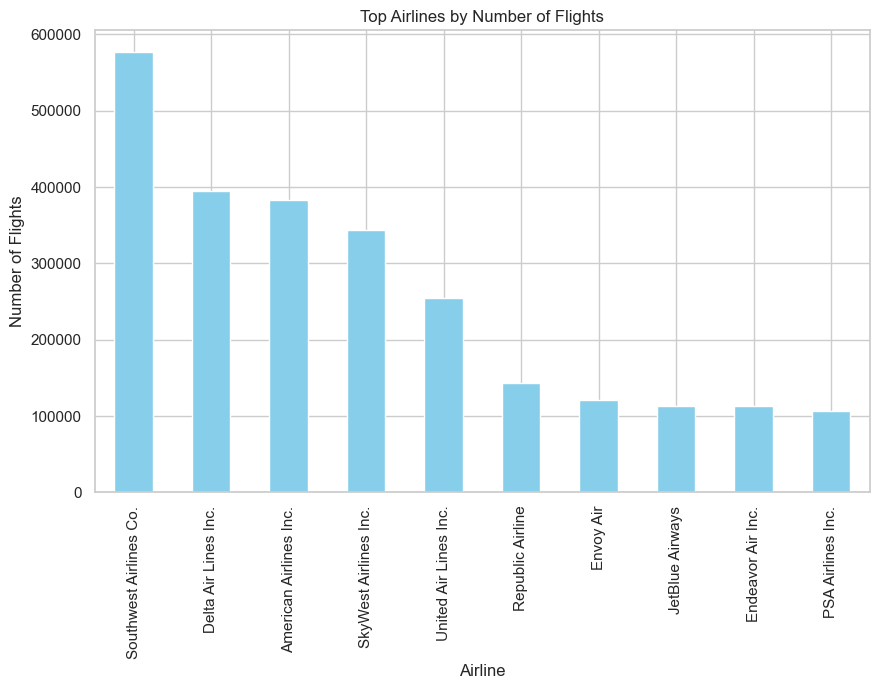

In [75]:
# 1. Top Airlines (by flight count)
plt.figure()
df['AIRLINE'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top Airlines by Number of Flights")
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.show()

In [76]:
# Extract and analyze available months from 2023 flight data
df_2023 = df[df['FL_DATE'].dt.year == 2023]

# Get unique months
unique_months_2023 = df_2023['FL_DATE'].dt.month.unique()

# Sort them
unique_months_2023.sort()

print("Months available in 2023:", unique_months_2023)
print("Number of months in dataset for 2023:", len(unique_months_2023))

Months available in 2023: [1 2 3 4 5 6 7 8]
Number of months in dataset for 2023: 8


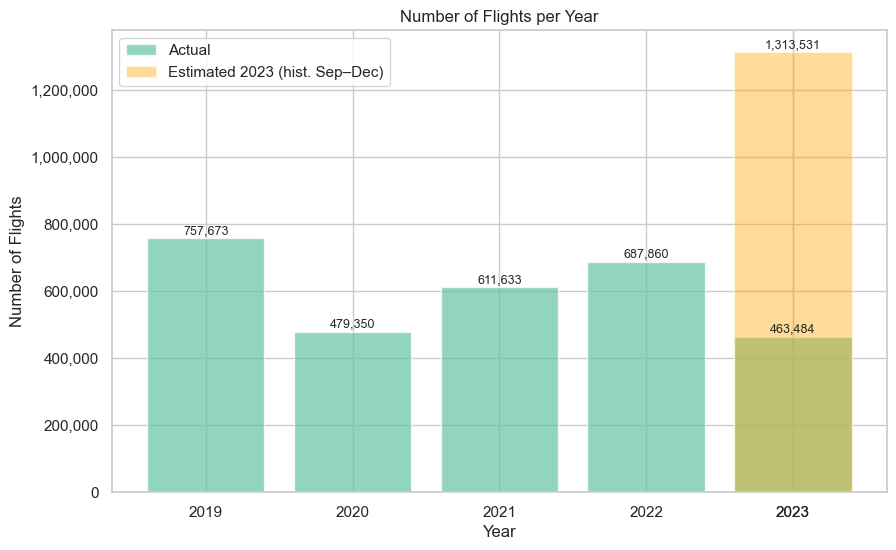

In [77]:
#---Number of Flights per Year---

# --- Ensure FL_DATE is datetime ---
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# --- Flights per year (actual) ---
flights_per_year = df['FL_DATE'].dt.year.value_counts().sort_index()

# --- Actual 2023 flights (Jan–Aug only) ---
df_2023 = df[(df['FL_DATE'].dt.year == 2023) & (df['FL_DATE'].dt.month <= 8)]
flights_2023_actual = df_2023.shape[0]

# --- Historical averages for Sep–Dec (all years before 2023) ---
df_prev = df[df['FL_DATE'].dt.year < 2023]
hist_sep_dec = (
    df_prev[df_prev['FL_DATE'].dt.month.isin([9,10,11,12])]
    .groupby(df_prev['FL_DATE'].dt.month)
    .size()
    .groupby(level=0)
    .mean()
)

# Estimate Sep–Dec 2023 using historical averages
sep_dec_est = int(hist_sep_dec.loc[9] + hist_sep_dec.loc[10] + hist_sep_dec.loc[11] + hist_sep_dec.loc[12])

# --- Total estimated 2023 ---
flights_2023_est = flights_2023_actual + sep_dec_est

# --- Plot ---
plt.figure(figsize=(10,6))
years = flights_per_year.index.astype(int)

# Bars
bars_actual = plt.bar(years, flights_per_year.values, alpha=0.7, label="Actual")
bar_est = plt.bar(2023, flights_2023_est, alpha=0.4, color="orange", label="Estimated 2023 (hist. Sep–Dec)")

# Titles and labels
plt.title("Number of Flights per Year")
plt.xlabel("Year")
plt.ylabel("Number of Flights")

# X-axis ticks
plt.xticks(list(years) + [2023])

# Format y-axis with commas
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# --- Annotate actual bars ---
for bar in bars_actual.patches:  # iterate through individual bars
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5000, f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# --- Annotate estimated 2023 bar ---
for bar in bar_est.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5000, f'{int(height):,}', ha='center', va='bottom', fontsize=9)

plt.legend()
plt.show()



## Insights: Number of Flights per Year

- **2019**: Around **760,000 flights** – peak before the COVID-19 pandemic.  
- **2020**: Dropped sharply to **~480,000 flights** due to the pandemic impact.  
- **2021**: Recovery begins with **~610,000 flights**.  
- **2022**: Continued growth reaching **~690,000 flights**.  
- **2023**: About **460,000 flights (Jan–Aug actual)**, with **Sep–Dec estimated from historical data → ~1.3M flights total**, indicating a **strong rebound, surpassing pre-COVID levels**.  


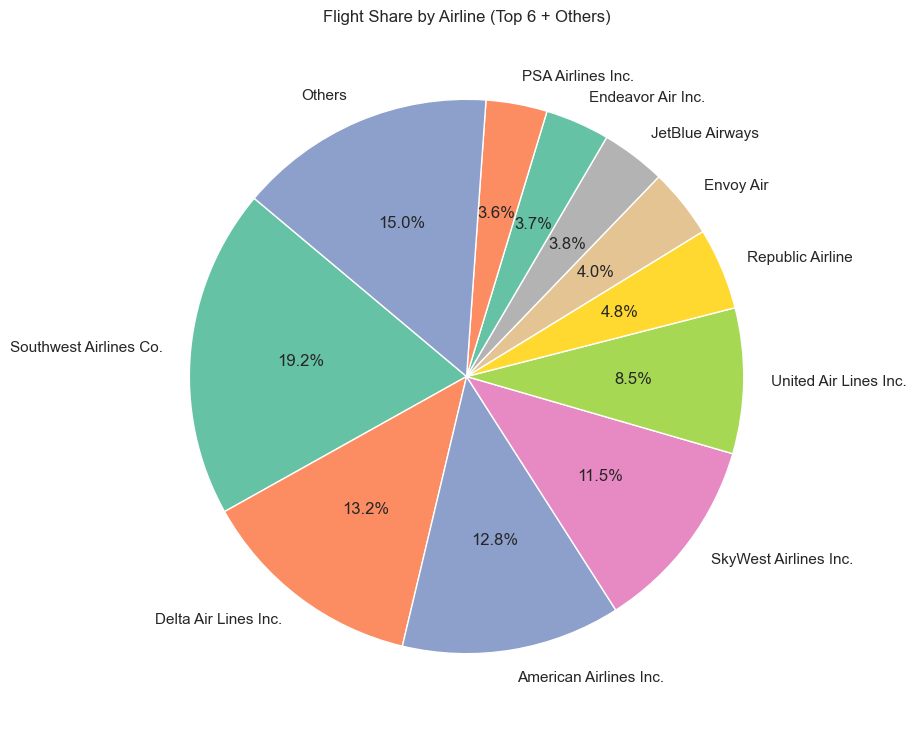

In [79]:
#---Top 10  Airlines---
airline_counts = df['AIRLINE'].value_counts()

# Keep top 10 airlines, group the rest
top_n = 10
top_airlines = airline_counts[:top_n]
others = pd.Series([airline_counts[top_n:].sum()], index=['Others'])

# Concatenate top + others
airline_counts_clean = pd.concat([top_airlines, others])

plt.figure(figsize=(9,9))
plt.pie(airline_counts_clean, labels=airline_counts_clean.index, autopct='%1.1f%%', startangle=140)
plt.title("Flight Share by Airline (Top 6 + Others)")
plt.show()



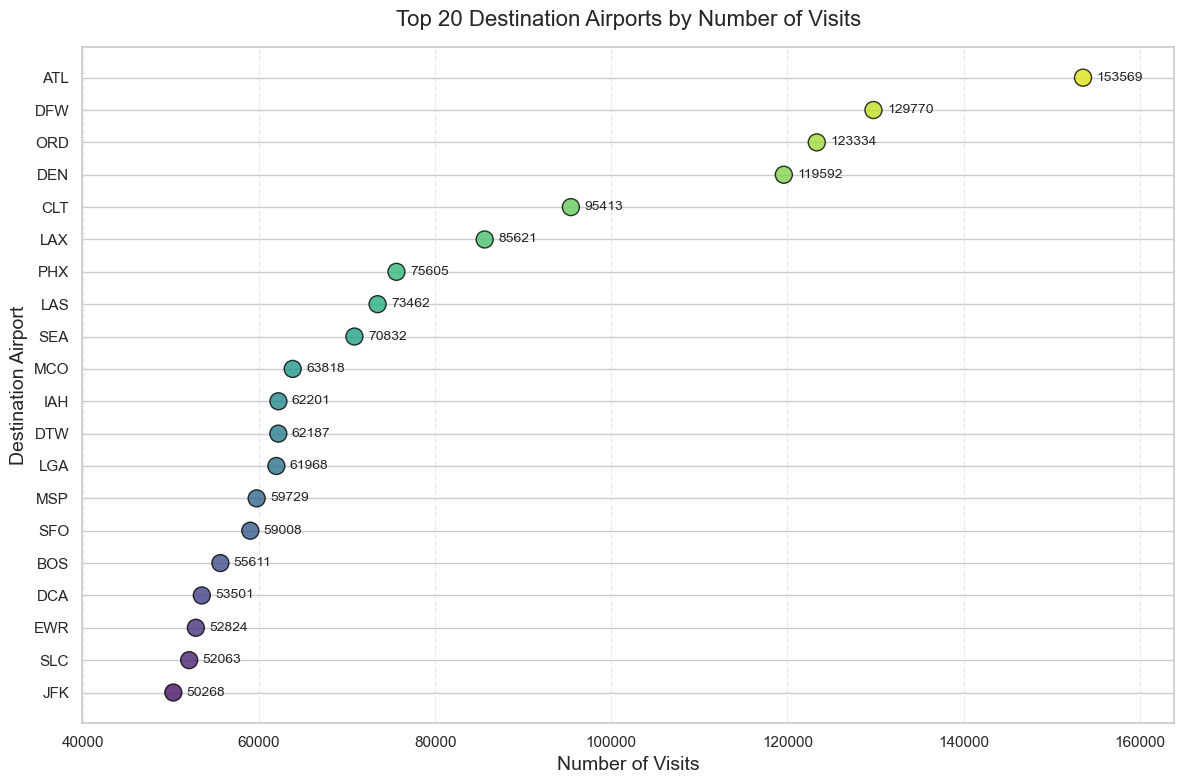

In [80]:
#--- Count visits per destination---
dest_counts = df['DEST'].value_counts().reset_index()
dest_counts.columns = ['DEST', 'count']

# Optionally, limit to top N destinations for readability
top_n = 20
dest_counts = dest_counts.head(top_n).sort_values('count')

plt.figure(figsize=(12, 8))

# Create a color palette
colors = sns.color_palette('viridis', len(dest_counts))

# Plot dot plot: dots positioned by count on x-axis, destinations on y-axis
plt.scatter(
    dest_counts['count'],
    dest_counts['DEST'],
    s=150,
    color=colors,
    edgecolors='black',
    alpha=0.8
)

# Annotate each dot with the count value
for i, (count, dest) in enumerate(zip(dest_counts['count'], dest_counts['DEST'])):
    plt.text(
        count + max(dest_counts['count']) * 0.01,  # small offset to right of dot
        dest,
        f'{count}',
        va='center',
        ha='left',
        fontsize=10
    )

plt.title(f'Top {top_n} Destination Airports by Number of Visits', fontsize=16, pad=15)
plt.xlabel('Number of Visits', fontsize=14)
plt.ylabel('Destination Airport', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Set x-axis limits to start slightly below the minimum count for better visual comparison
min_count = dest_counts['count'].min()
max_count = dest_counts['count'].max()
padding = (max_count - min_count) * 0.1  # 10% padding
plt.xlim(min_count - padding, max_count + padding)

plt.tight_layout()
plt.show()
#m2

***Destination Visits Dot Plot***

This plot shows the number of visits to each destination airport, focusing on the top destinations. Instead of starting the axis at zero, the x-axis begins near the smallest count to better highlight differences between destinations. Each dot represents a destination, with annotations showing the exact visit counts.

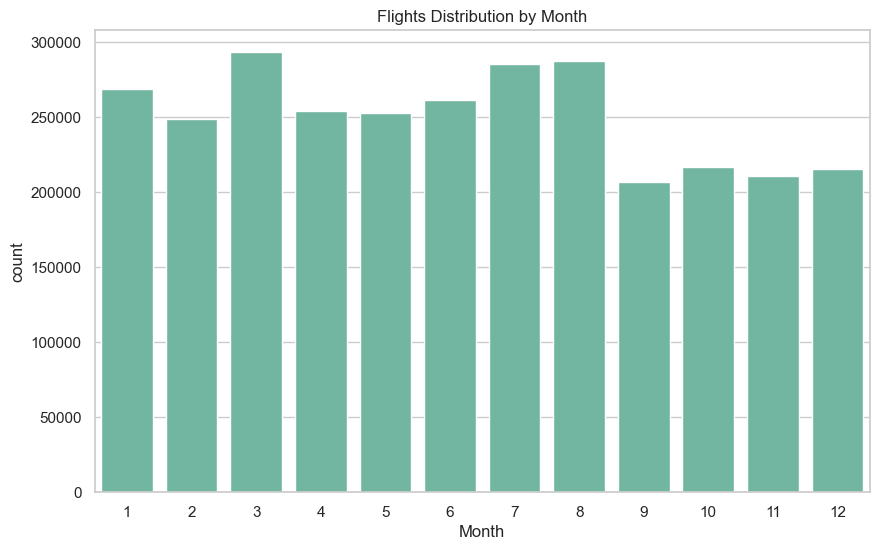

In [82]:
# ---Busiest Months (Flights per Month)---
plt.figure()
sns.countplot(x='Month', data=df, order=sorted(df['Month'].unique()))
plt.title("Flights Distribution by Month")
plt.show()

In [83]:
# Shift values so 0=Sunday becomes 7
df['DayOfWeek'] = df['DayOfWeek'].replace({0:7})


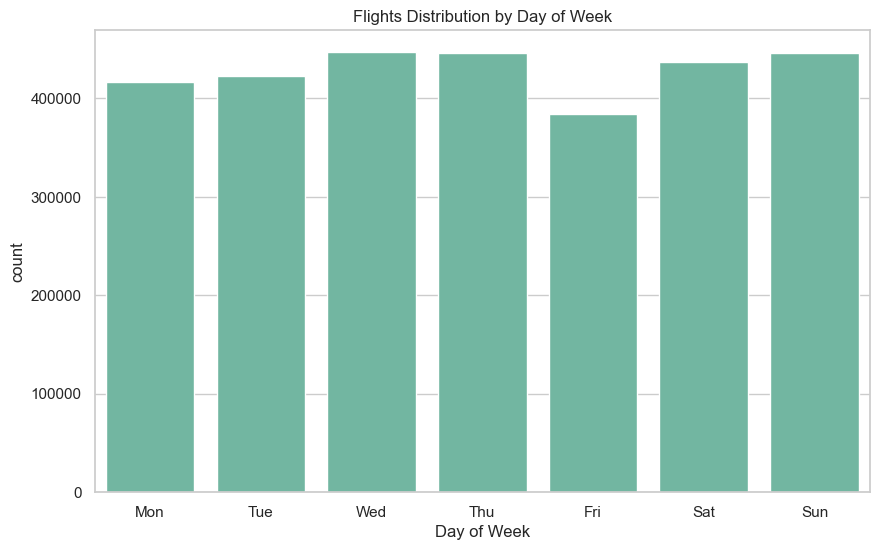

In [84]:
#---Number of flights in a week---
day_map = {1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'}
df['DayOfWeekName'] = df['DayOfWeek'].map(day_map)

plt.figure()
sns.countplot(x='DayOfWeekName', data=df, 
              order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title("Flights Distribution by Day of Week")
plt.xlabel("Day of Week")
plt.show()

In [85]:
df['dep_hour'] = pd.to_datetime(df['dep_time'], format='%H:%M:%S', errors='coerce').dt.hour
df['arr_hour'] = pd.to_datetime(df['arr_time'], format='%H:%M:%S', errors='coerce').dt.hour

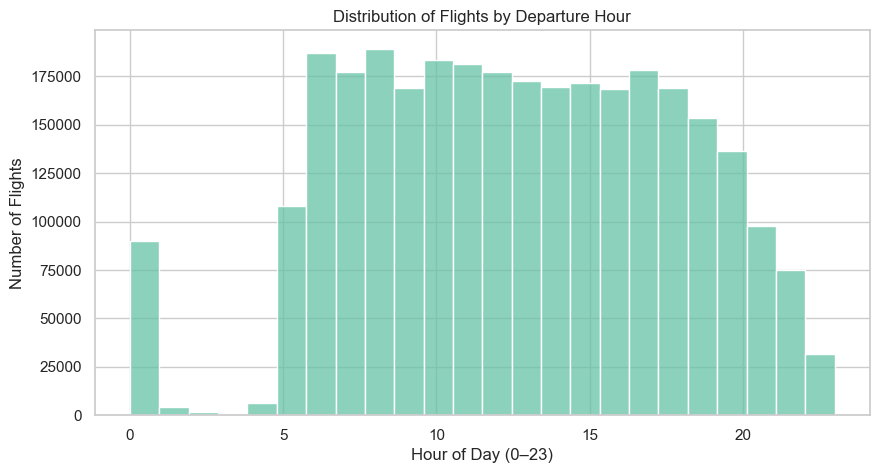

In [86]:
#---Distribution of Flights by Departure Hour---
plt.figure(figsize=(10,5))
sns.histplot(df['dep_hour'], bins=24, kde=False)
plt.title("Distribution of Flights by Departure Hour")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Flights")
plt.show()

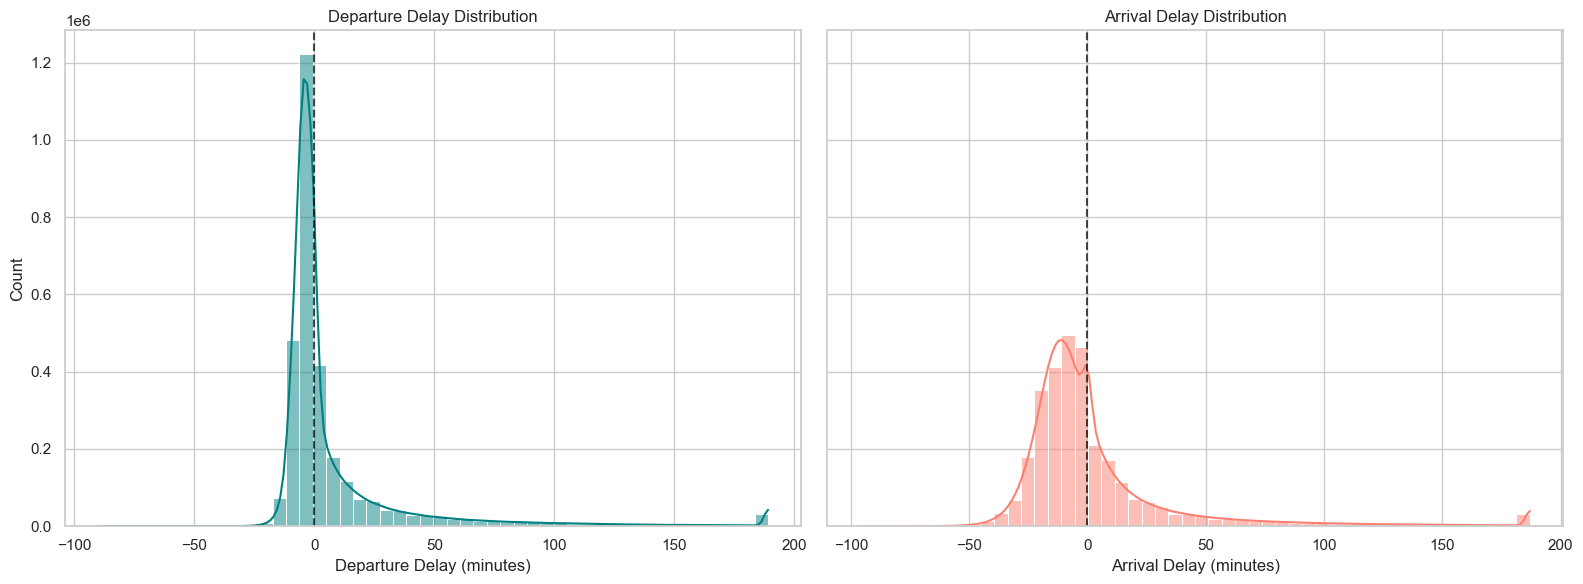

In [87]:
#---Delay Distribution---

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- Histogram 1: Departure Delays ---
sns.histplot(df['DEP_DELAY'], bins=50, kde=True, color="teal", ax=axes[0])
axes[0].set_title("Departure Delay Distribution")
axes[0].set_xlabel("Departure Delay (minutes)")
axes[0].axvline(0, color="black", linestyle="--", alpha=0.7)  # vertical reference at 0

# --- Histogram 2: Arrival Delays ---
sns.histplot(df['ARR_DELAY'], bins=50, kde=True, color="salmon", ax=axes[1])
axes[1].set_title("Arrival Delay Distribution")
axes[1].set_xlabel("Arrival Delay (minutes)")
axes[1].axvline(0, color="black", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

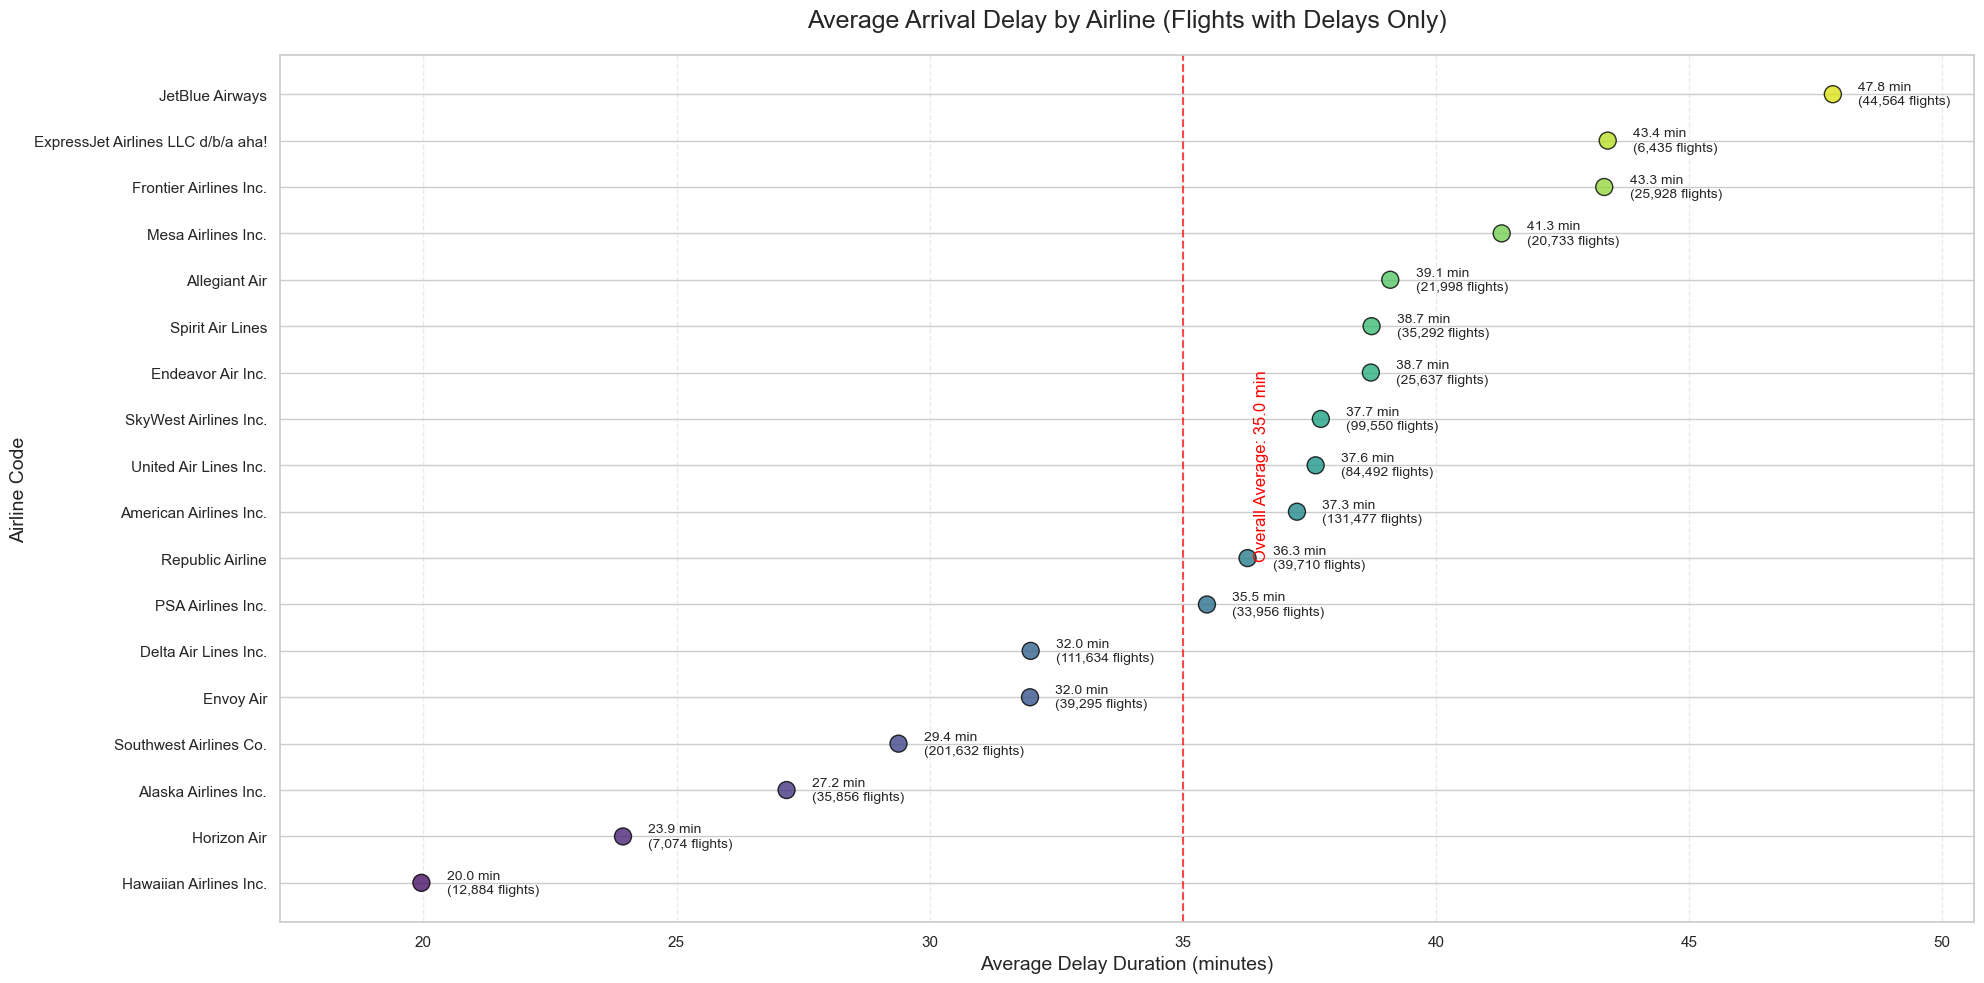


Additional Insights:
- Worst performing airline: JetBlue Airways (47.8 min avg delay)
- Best performing airline: Hawaiian Airlines Inc. (20.0 min avg delay)
- Total flights analyzed: 978,147
- Percentage of flights delayed: 32.6%


In [88]:
#---Average Arrival Delay by Airline---

# Clean data - remove rows with missing airline or delay info
df_cleaned = df.dropna(subset=['AIRLINE', 'ARR_DELAY'])

# Filter for delayed flights only (optional)
df_delayed = df_cleaned[df_cleaned['ARR_DELAY'] > 0]

# Calculate average delays by airline
avg_delay = df_delayed.groupby('AIRLINE')['ARR_DELAY'].agg(['mean', 'count']).reset_index()
avg_delay = avg_delay.rename(columns={'mean': 'avg_delay', 'count': 'flight_count'})

# Filter airlines with sufficient data (e.g., at least 100 flights)
avg_delay = avg_delay[avg_delay['flight_count'] >= 100].sort_values('avg_delay').reset_index(drop=True)

plt.figure(figsize=(20, 10))

# Create color palette
colors = sns.color_palette('viridis', len(avg_delay))

# Plot dots
plt.scatter(
    avg_delay['avg_delay'],
    avg_delay['AIRLINE'],
    s=150,
    color=colors,
    edgecolors='black',
    alpha=0.8
)

# Annotate each dot with delay and flight count
for i, (delay, count) in enumerate(zip(avg_delay['avg_delay'], avg_delay['flight_count'])):
    plt.text(
        delay + 0.5, i,
        f'{delay:.1f} min\n({count:,} flights)',
        va='center',
        ha='left',
        fontsize=10
    )

plt.title('Average Arrival Delay by Airline (Flights with Delays Only)', fontsize=18, pad=20)
plt.xlabel('Average Delay Duration (minutes)', fontsize=14)
plt.ylabel('Airline Code', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Set x-axis limits starting slightly below the minimum delay value for better visual comparison
min_delay = avg_delay['avg_delay'].min()
max_delay = avg_delay['avg_delay'].max()
padding = (max_delay - min_delay) * 0.1  # 10% padding
plt.xlim(min_delay - padding, max_delay + padding)

# Add overall average delay reference line
mean_delay = df_delayed['ARR_DELAY'].mean()
plt.axvline(mean_delay, color='red', linestyle='--', alpha=0.7)
plt.text(
    mean_delay + padding / 2, len(avg_delay) / 2,
    f'Overall Average: {mean_delay:.1f} min',
    rotation=90,
    va='center',
    color='red'
)

plt.tight_layout()
plt.show()

# Additional insights
print("\nAdditional Insights:")
print(f"- Worst performing airline: {avg_delay.iloc[-1]['AIRLINE']} ({avg_delay.iloc[-1]['avg_delay']:.1f} min avg delay)")
print(f"- Best performing airline: {avg_delay.iloc[0]['AIRLINE']} ({avg_delay.iloc[0]['avg_delay']:.1f} min avg delay)")
print(f"- Total flights analyzed: {avg_delay['flight_count'].sum():,}")
print(f"- Percentage of flights delayed: {len(df_delayed) / len(df_cleaned) * 100:.1f}%")

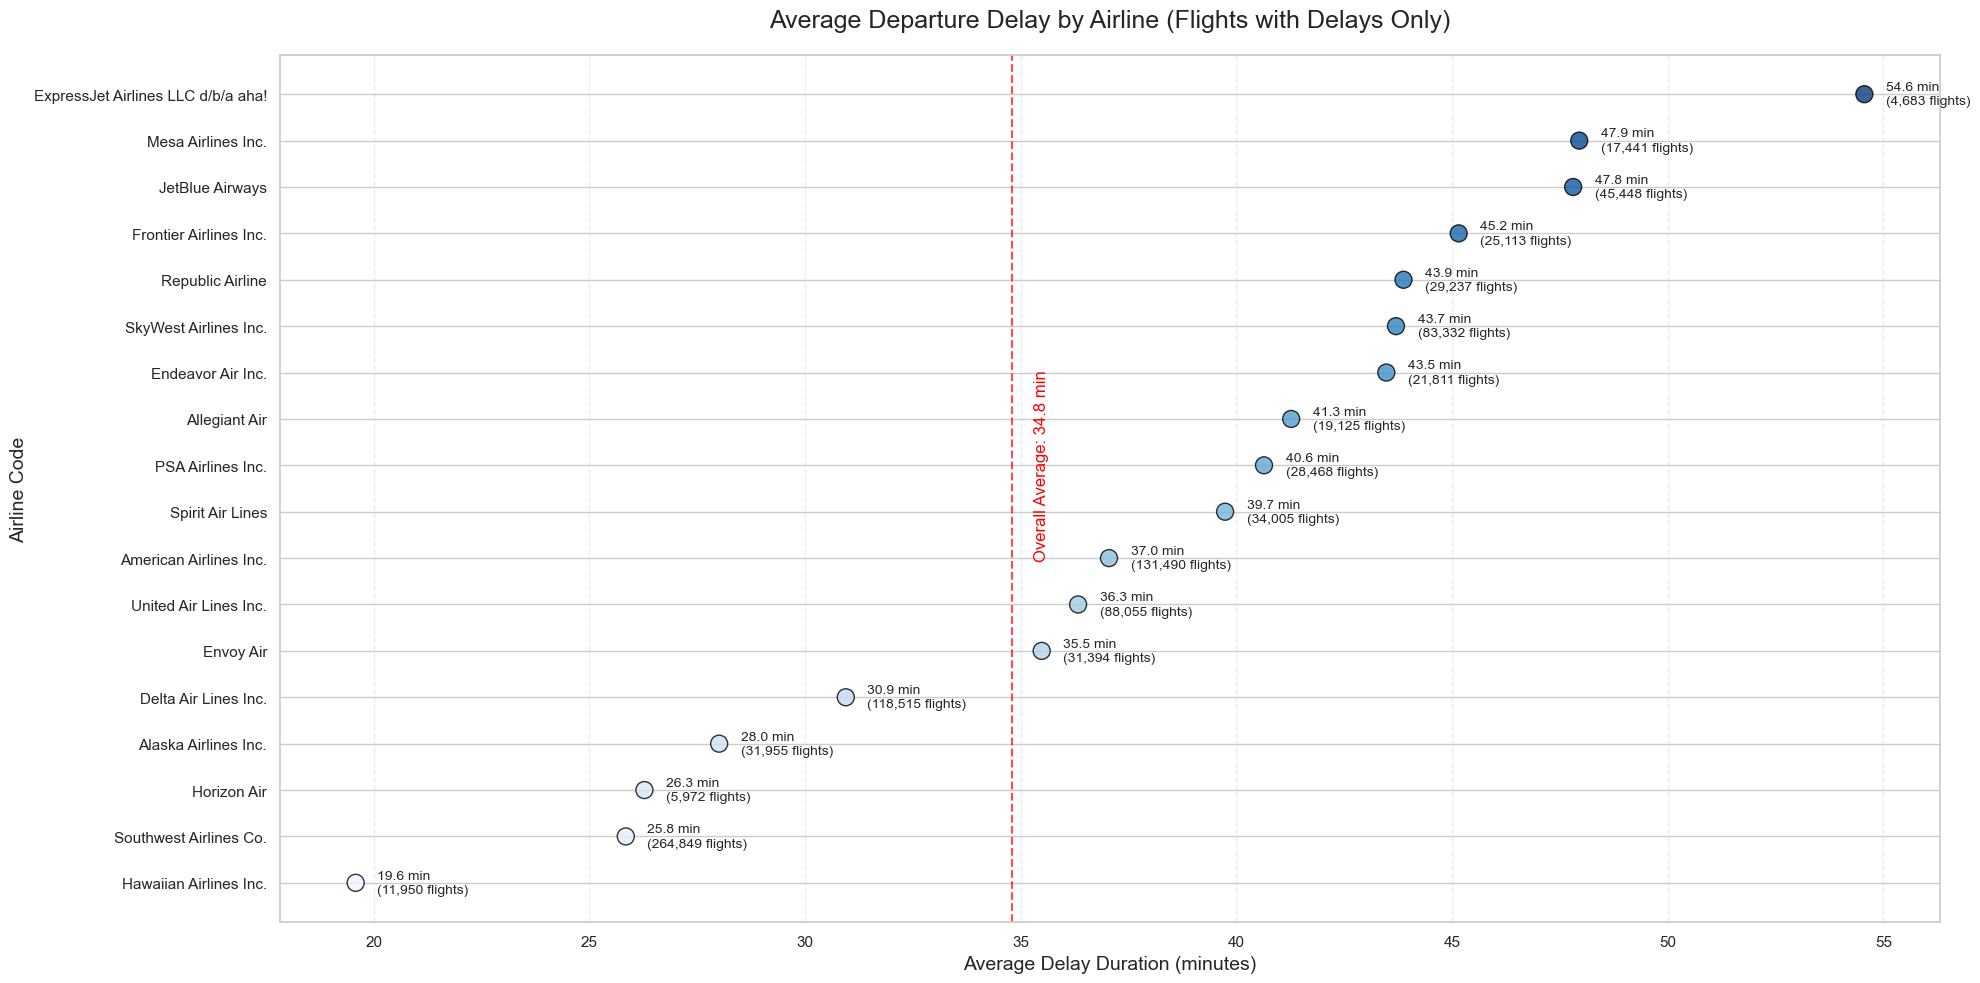


Additional Insights (Departure Delays Only):
- Worst performing airline: ExpressJet Airlines LLC d/b/a aha! (54.6 min avg delay)
- Best performing airline: Hawaiian Airlines Inc. (19.6 min avg delay)
- Total flights analyzed: 992,843
- Percentage of flights delayed: 33.1%


In [89]:
#---Average Departure Delay by Airline---

# Clean data - remove rows with missing airline or departure delay info
df_cleaned = df.dropna(subset=['AIRLINE', 'DEP_DELAY'])

# Filter for delayed flights only (same logic as arrival delays)
df_dep_delayed = df_cleaned[df_cleaned['DEP_DELAY'] > 0]

# Calculate average departure delays by airline
avg_dep_delay = df_dep_delayed.groupby('AIRLINE')['DEP_DELAY'].agg(['mean', 'count']).reset_index()
avg_dep_delay = avg_dep_delay.rename(columns={'mean': 'avg_delay', 'count': 'flight_count'})

# Filter airlines with sufficient data (e.g., at least 100 flights)
avg_dep_delay = avg_dep_delay[avg_dep_delay['flight_count'] >= 100].sort_values('avg_delay').reset_index(drop=True)

plt.figure(figsize=(20, 10))

# Create color palette
colors = sns.color_palette('Blues', len(avg_dep_delay))

# Plot dots
plt.scatter(
    avg_dep_delay['avg_delay'],
    avg_dep_delay['AIRLINE'],
    s=150,
    color=colors,
    edgecolors='black',
    alpha=0.8
)

# Annotate each dot with delay and flight count
for i, (delay, count) in enumerate(zip(avg_dep_delay['avg_delay'], avg_dep_delay['flight_count'])):
    plt.text(
        delay + 0.5, i,
        f'{delay:.1f} min\n({count:,} flights)',
        va='center',
        ha='left',
        fontsize=10
    )

plt.title('Average Departure Delay by Airline (Flights with Delays Only)', fontsize=18, pad=20)
plt.xlabel('Average Delay Duration (minutes)', fontsize=14)
plt.ylabel('Airline Code', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Add overall average departure delay reference line
mean_dep_delay = df_dep_delayed['DEP_DELAY'].mean()
plt.axvline(mean_dep_delay, color='red', linestyle='--', alpha=0.7)
plt.text(
    mean_dep_delay + 0.5, len(avg_dep_delay) / 2,
    f'Overall Average: {mean_dep_delay:.1f} min',
    rotation=90,
    va='center',
    color='red'
)

plt.tight_layout()
plt.show()

# Additional insights
print("\nAdditional Insights (Departure Delays Only):")
print(f"- Worst performing airline: {avg_dep_delay.iloc[-1]['AIRLINE']} ({avg_dep_delay.iloc[-1]['avg_delay']:.1f} min avg delay)")
print(f"- Best performing airline: {avg_dep_delay.iloc[0]['AIRLINE']} ({avg_dep_delay.iloc[0]['avg_delay']:.1f} min avg delay)")
print(f"- Total flights analyzed: {avg_dep_delay['flight_count'].sum():,}")
print(f"- Percentage of flights delayed: {len(df_dep_delayed) / len(df_cleaned) * 100:.1f}%")


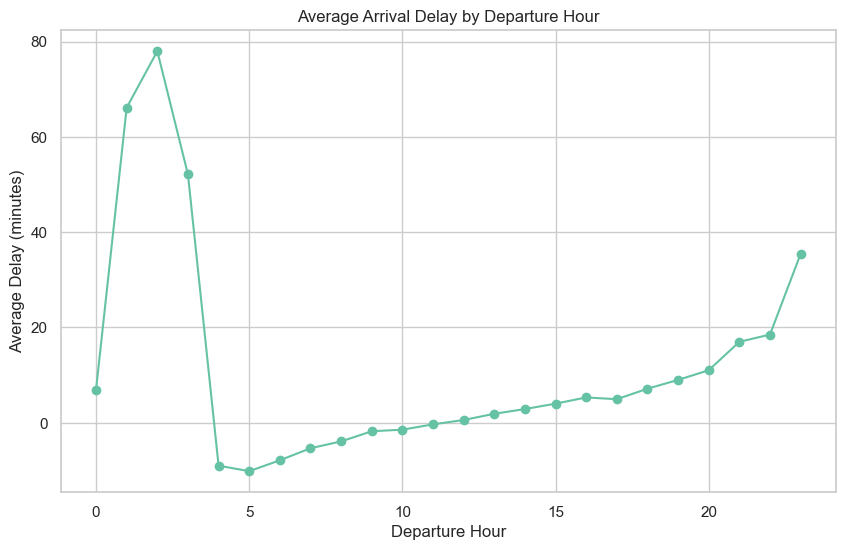

In [90]:
#---Average Arrival Delay by Time of Day (Departure Hour)---
plt.figure()
df.groupby("dep_hour")['ARR_DELAY'].mean().plot(kind='line', marker='o')
plt.title("Average Arrival Delay by Departure Hour")
plt.xlabel("Departure Hour")
plt.ylabel("Average Delay (minutes)")
plt.show()

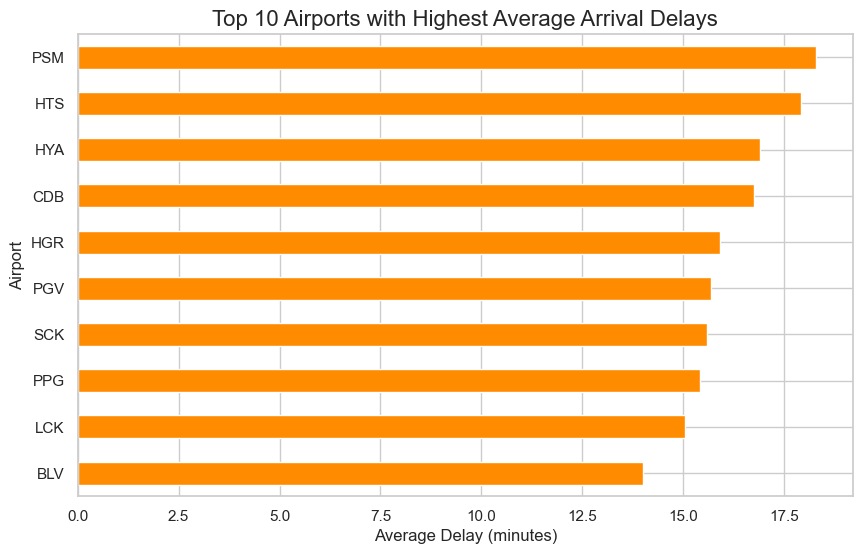

In [91]:
#---Average Arrival Delay by Airport (Top 10 Origins)---
top10_arr_delay = df.groupby("ORIGIN")['ARR_DELAY'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top10_arr_delay.plot(kind='barh', color='darkorange')
plt.title("Top 10 Airports with Highest Average Arrival Delays", fontsize=16)
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Airport")
plt.gca().invert_yaxis()  # Optional: highest delay on top
plt.show()


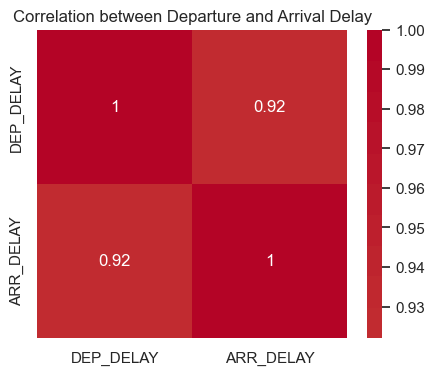

In [92]:
#---correlation heatmap---
plt.figure(figsize=(5,4))
sns.heatmap(df[['DEP_DELAY','ARR_DELAY']].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Departure and Arrival Delay")
plt.show()


### Correlation between Departure Delay and Arrival Delay

- **Correlation = 0.92** → very strong positive relationship between departure and arrival delays.  
- **Meaning**: Flights that depart late almost always arrive late too.  
- **Not perfect (not 1.0)** → some flights recover time in the air, others lose more due to congestion.  
- **Insight**: Improving **departure punctuality** directly improves **on-time arrivals**.


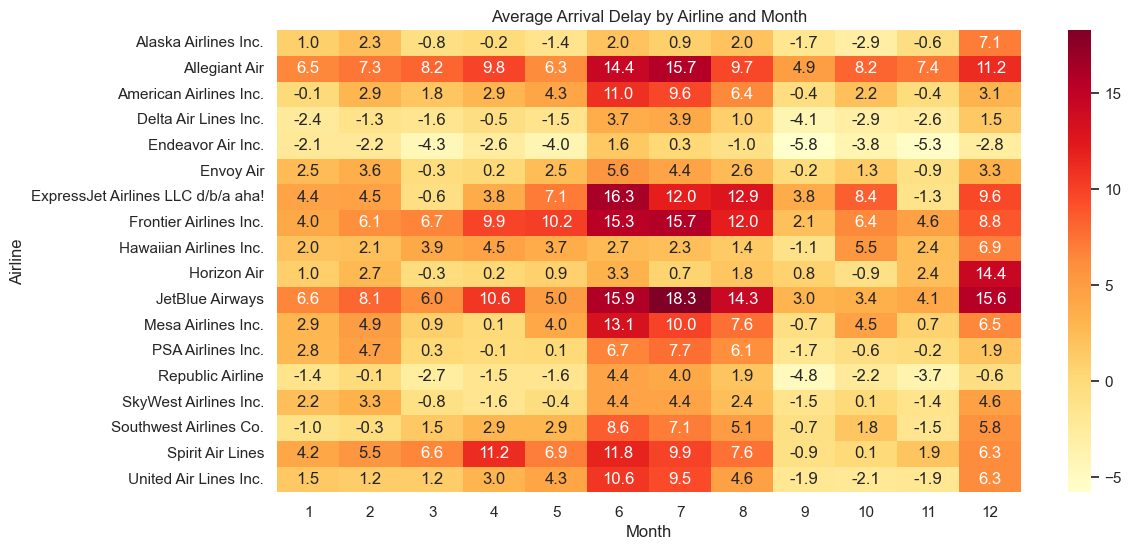

In [94]:
#---Average Arrival Delay by Airline and Month---

# Compute average arrival delay by airline and month
airline_month_delay = df.groupby(['AIRLINE', 'Month'])['ARR_DELAY'].mean().reset_index()

# Pivot for heatmap
pivot_table = airline_month_delay.pivot(index="AIRLINE", columns="Month", values="ARR_DELAY")

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Average Arrival Delay by Airline and Month")
plt.ylabel("Airline")
plt.xlabel("Month")
plt.show()

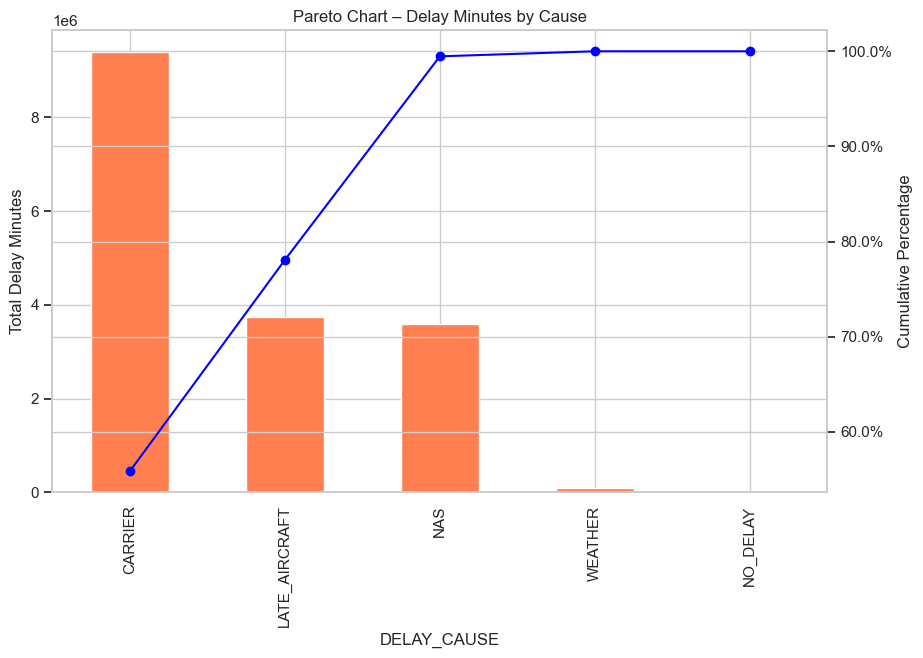

In [95]:
# ---Delay minutes by cause---
delay_cause = df.groupby('DELAY_CAUSE')['DELAY_MINUTES'].sum().sort_values(ascending=False)

# Cumulative percentage
cum_percentage = delay_cause.cumsum() / delay_cause.sum() * 100

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar chart (delay minutes by cause)
delay_cause.plot(kind='bar', color='coral', ax=ax1)
ax1.set_ylabel("Total Delay Minutes")

# Line chart (cumulative %)
ax2 = ax1.twinx()
cum_percentage.plot(color='blue', marker='o', ax=ax2)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylabel("Cumulative Percentage")

plt.title("Pareto Chart – Delay Minutes by Cause")
plt.show()

# 📌 **Milestone 3: Route, Cancellation, and Seasonal Insights**


In [97]:
# ---Top 10 busiest routes---

top10_routes = df["Route"].value_counts().head(10).reset_index()
top10_routes.columns = ["Route", "Flights"]

# Split into Origin and Destination for clarity
top10_routes[["Origin", "Destination"]] = top10_routes["Route"].str.split("-", expand=True)

# Reorder columns
top10_routes = top10_routes[["Origin", "Destination", "Flights"]]

# Display as table
import IPython.display as disp
disp.display(top10_routes)


,Origin,Destination,Flights
0,SFO,LAX,5358
1,LAX,SFO,5212
2,LGA,ORD,4735
3,OGG,HNL,4656
4,ORD,LGA,4634
5,LAX,LAS,4627
6,HNL,OGG,4554
7,LAS,LAX,4550
8,LAX,JFK,4403
9,JFK,LAX,4305


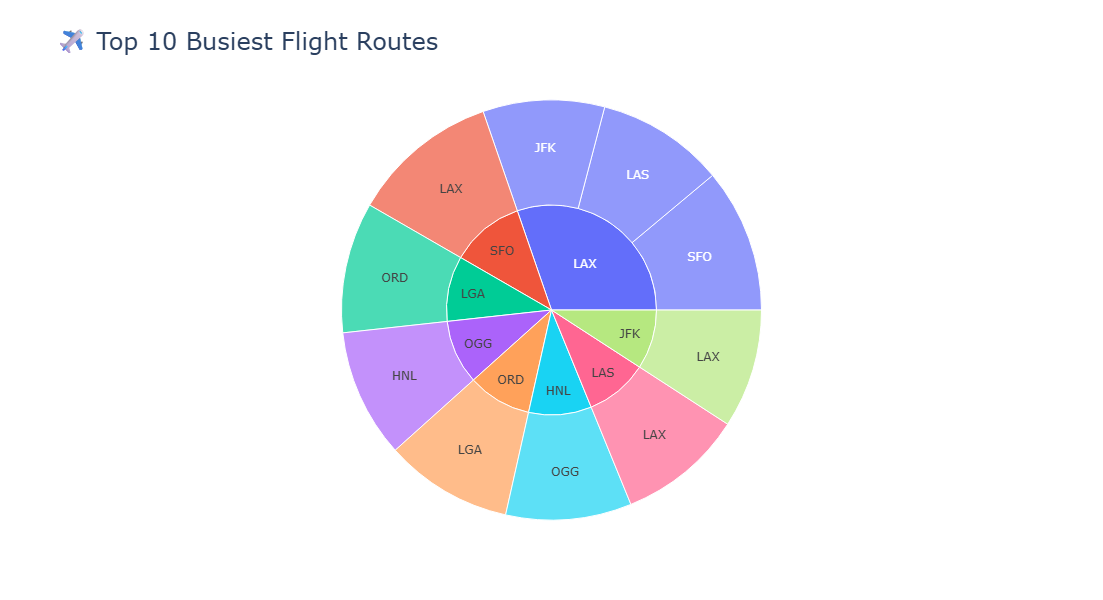

In [98]:
#---Top 10 busiest routes---
route_counts = df["Route"].value_counts().head(10).reset_index()
route_counts.columns = ["Route","Flights"]

# Split Route into ORIGIN and DEST
route_counts[["ORIGIN","DEST"]] = route_counts["Route"].str.split("-", expand=True)

# Sunburst plot
fig = px.sunburst(
    route_counts,
    path=["ORIGIN","DEST"],   # hierarchy: Origin → Destination
    values="Flights",
    title="✈️ Top 10 Busiest Flight Routes"
)


# Increase figure size
fig.update_layout(
    width=600,   # increase width
    height=600,  # increase height
    title_font=dict(size=24)  # make title text larger
)


fig.show()


### 📝 Insights
- **West Coast Dominance**: The **LAX–SFO** corridor is the busiest, highlighting strong business and leisure demand between Southern and Northern California.  
- **Island Connectivity**: Routes like **OGG–HNL** and **HNL–OGG** rank high due to inter-island travel needs in Hawaii.  
- **East Coast–Midwest Hub**: **LGA–ORD** and **ORD–LGA** are key business routes linking New York City with Chicago.  
- **Leisure Travel Hotspot**: **LAX–LAS** is among the top routes, driven by tourism and weekend travel.  
- **Transcontinental Routes**: **LAX–JFK** and **JFK–LAX** highlight strong coast-to-coast demand.  

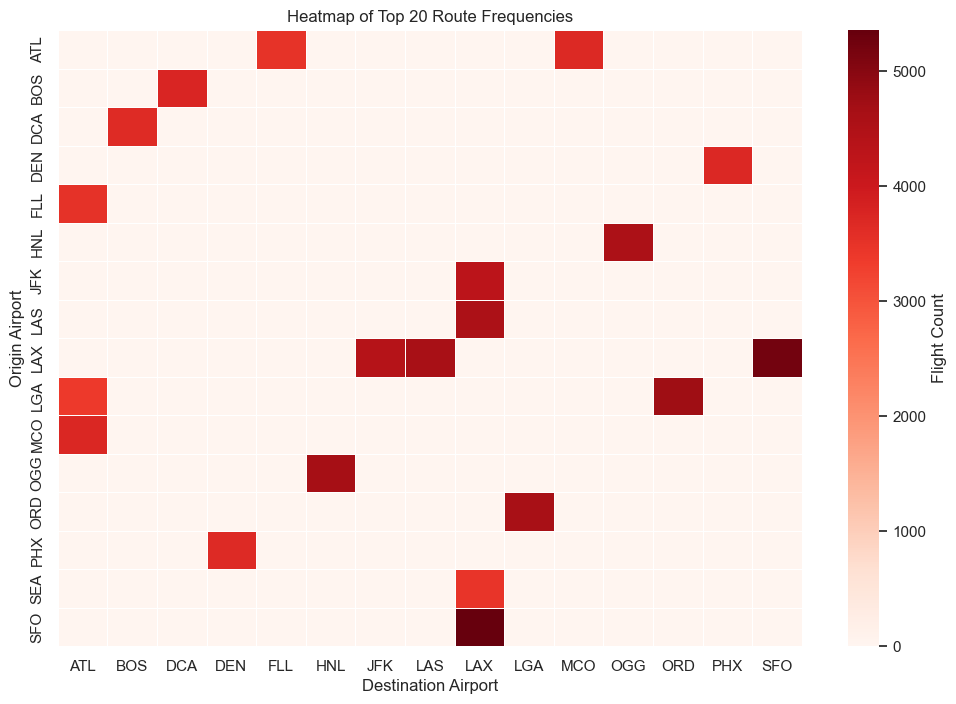

In [100]:
# ---Count total flights per route---
top_routes = df.groupby(['ORIGIN', 'DEST']).size().sort_values(ascending=False).head(20)
route_matrix_top = top_routes.reset_index().pivot(index='ORIGIN', columns='DEST', values=0).fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(route_matrix_top, cmap="Reds", linewidths=.5, cbar_kws={'label': 'Flight Count'})
plt.title("Heatmap of Top 20 Route Frequencies")
plt.xlabel("Destination Airport")
plt.ylabel("Origin Airport")
plt.show()

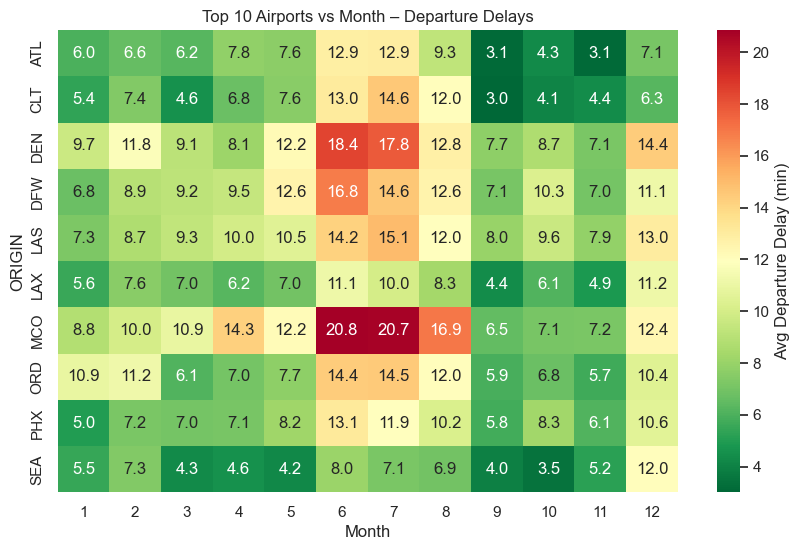

In [101]:
# Avg DEP_DELAY per airport per month
top_airports = df['ORIGIN'].value_counts().head(10).index

airport_month = (df[df['ORIGIN'].isin(top_airports)]
                   .groupby(['ORIGIN','Month'])['DEP_DELAY']
                   .mean()
                   .reset_index()
                   .pivot(index='ORIGIN', columns='Month', values='DEP_DELAY'))

plt.figure(figsize=(10,6))
sns.heatmap(airport_month, cmap="RdYlGn_r", annot=True, fmt=".1f",
            cbar_kws={'label':'Avg Departure Delay (min)'})
plt.title("Top 10 Airports vs Month – Departure Delays")
plt.show()


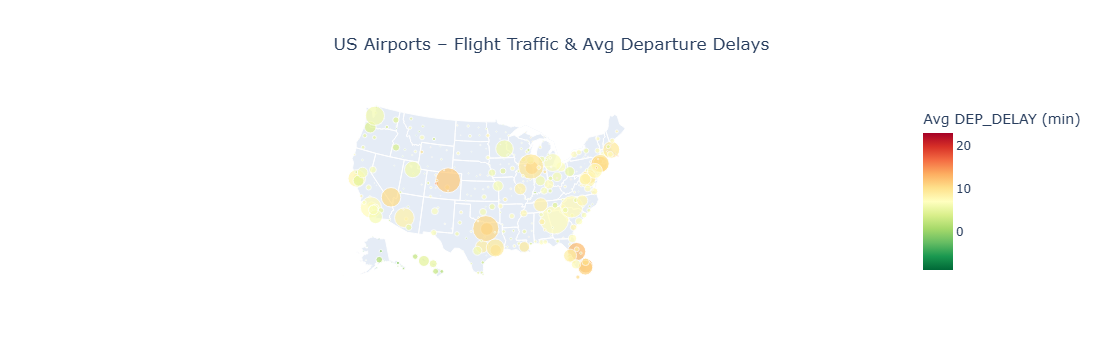

In [102]:
#---US Airports – Flight Traffic & Avg Departure Delays---

# --- Load data ---
airports_global = pd.read_csv(r'C:\Users\User\OneDrive\Desktop\Projects\Airlines Analysis\airports.csv')

# Standardize IATA codes
df['ORIGIN'] = df['ORIGIN'].str.upper().str.strip()
airports_global['IATA'] = airports_global['IATA'].str.upper().str.strip()

# Filter only US airports
airports_us = airports_global[airports_global['Country_CodeA2'] == 'US']

# Aggregate flight stats per airport
airport_stats = df.groupby('ORIGIN').agg(
    Flights=('FL_DATE','count'),
    Avg_DEP_DELAY=('DEP_DELAY','mean')
).reset_index()

# Merge flight stats with airport coordinates
airport_stats = airport_stats.merge(
    airports_us[['IATA','GeoPointLat','GeoPointLong']],
    left_on='ORIGIN',
    right_on='IATA',
    how='left'
)

# Remove airports with missing coordinates
airport_stats = airport_stats.dropna(subset=['GeoPointLat','GeoPointLong'])

# Scale marker size for better visualization
max_flights = airport_stats['Flights'].max()
airport_stats['Size'] = airport_stats['Flights'] / max_flights * 50  # scale 0-50

# Optional: highlight only top 20 busiest airports
# airport_stats = airport_stats.nlargest(20, 'Flights')

# --- Plot interactive map ---
fig = px.scatter_geo(
    airport_stats,
    lat='GeoPointLat',
    lon='GeoPointLong',
    hover_name='ORIGIN',
    size='Size',
    color='Avg_DEP_DELAY',
    color_continuous_scale='RdYlGn_r',  # green = low delay, red = high
    projection='albers usa',             # zoom in on US
    title='US Airports – Flight Traffic & Avg Departure Delays'
)

fig.update_layout(
    geo_scope='usa',                      
    coloraxis_colorbar=dict(title="Avg DEP_DELAY (min)"),
    title_x=0.5
)

fig.show()


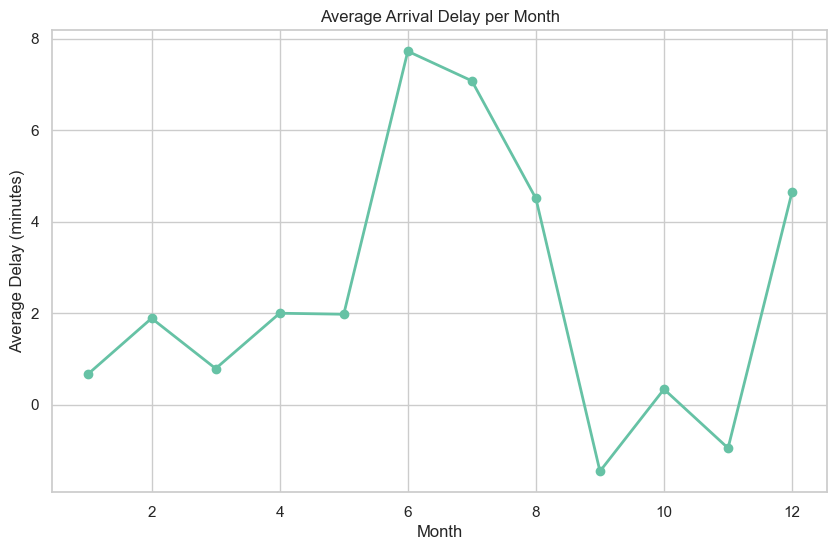

In [103]:
#---Average Arrival Delay per Month---
df['Month'] = df['FL_DATE'].dt.month
monthly_delay = df.groupby('Month')['ARR_DELAY'].mean()

plt.figure(figsize=(10,6))
plt.plot(monthly_delay.index, monthly_delay.values, marker='o', linestyle='-', linewidth=2)
plt.title("Average Arrival Delay per Month")
plt.xlabel("Month")
plt.ylabel("Average Delay (minutes)")
plt.grid(True)
plt.show()

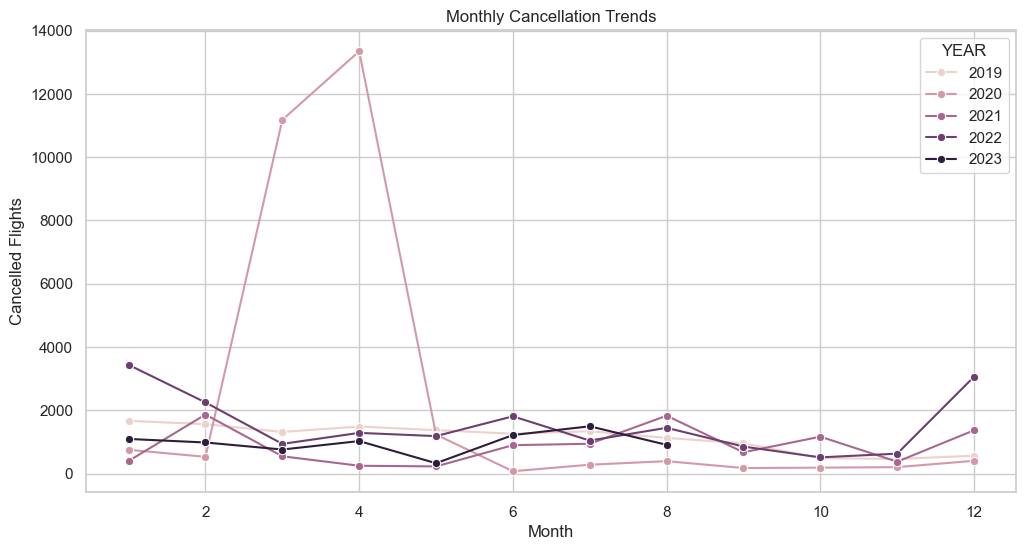

In [104]:
#---Monthly Cancellation Trends---

monthly_cancellations = (df.groupby(['YEAR','Month'])
                           ['CANCELLED']
                           .sum()
                           .reset_index())

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_cancellations, x='Month', y='CANCELLED', hue='YEAR', marker="o")
plt.title("Monthly Cancellation Trends")
plt.ylabel("Cancelled Flights")
plt.xlabel("Month")
plt.show()

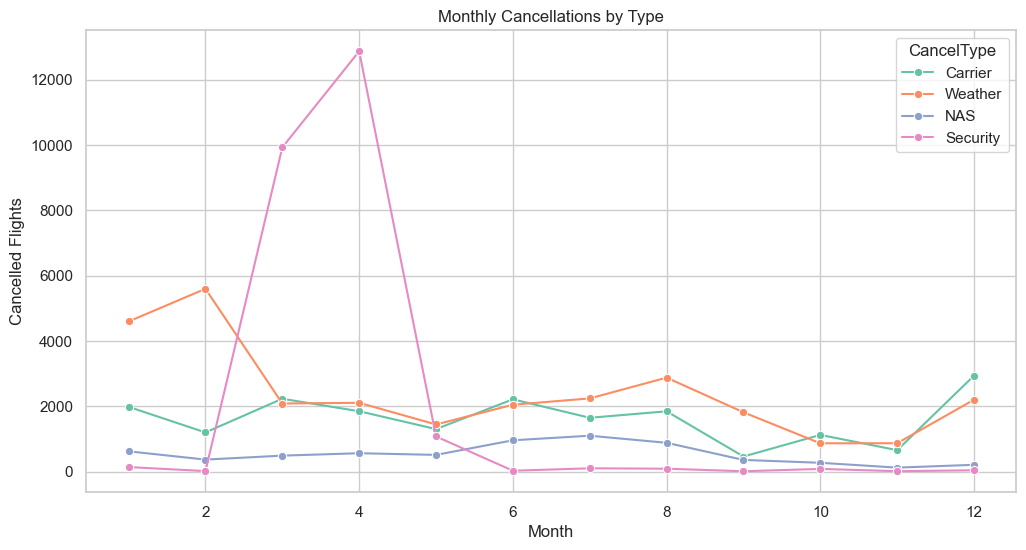

In [105]:
#---Monthly Cancellations by Type---

# Columns for cancellation types
cancel_cols = ['Cancelled_Carrier', 'Cancelled_Weather', 'Cancelled_NAS', 'Cancelled_Security']

# Group by month and sum cancellations
cancel_type = df.groupby('Month')[cancel_cols].sum().reset_index()

# Melt the DataFrame to long format for seaborn
cancel_type_melted = cancel_type.melt(id_vars='Month', 
                                      value_vars=cancel_cols, 
                                      var_name='CancelType', 
                                      value_name='CANCELLED')

# Optional: clean up names
cancel_type_melted['CancelType'] = cancel_type_melted['CancelType'].str.replace('Cancelled_', '')

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=cancel_type_melted, x='Month', y='CANCELLED', hue='CancelType', marker="o")
plt.title("Monthly Cancellations by Type")
plt.ylabel("Cancelled Flights")
plt.xlabel("Month")
plt.show()

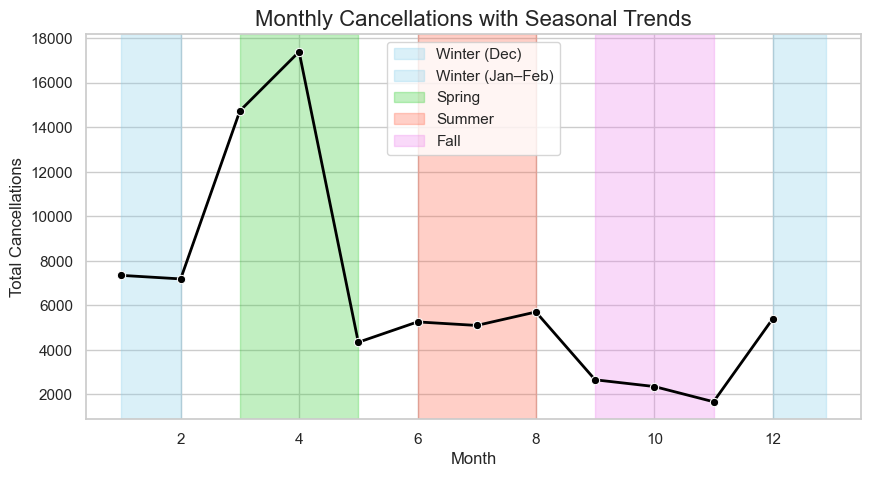

In [106]:
#---Monthly Cancellations with Seasonal Trends---

monthly_cancels = df.groupby('Month')['CANCELLED'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_cancels, x='Month', y='CANCELLED', marker="o", linewidth=2, color="black")
plt.title("Monthly Cancellations with Seasonal Trends", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Total Cancellations")

# Winter split into two spans: Dec + Jan–Feb
plt.axvspan(12, 12.9, color="skyblue", alpha=0.3, label="Winter (Dec)")  
plt.axvspan(1, 2, color="skyblue", alpha=0.3, label="Winter (Jan–Feb)")  

# Other seasons
plt.axvspan(3, 5, color="limegreen", alpha=0.3, label="Spring")
plt.axvspan(6, 8, color="tomato", alpha=0.3, label="Summer")
plt.axvspan(9, 11, color="violet", alpha=0.3, label="Fall")

plt.legend()
plt.show()




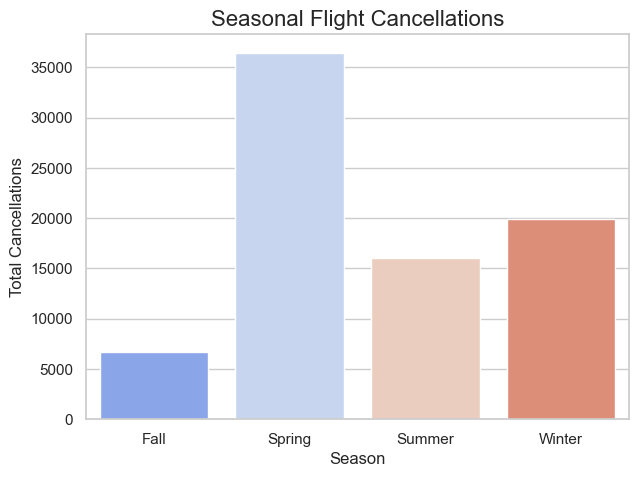

In [107]:
#---Seasonal Flight Cancellations---

# Define seasons
def get_season(month):
    if month in [12,1,2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

# Group cancellations per season
season_cancels = df.groupby('Season')['CANCELLED'].sum().reset_index()

plt.figure(figsize=(7,5))
sns.barplot(data=season_cancels, x='Season', y='CANCELLED', palette="coolwarm")
plt.title("Seasonal Flight Cancellations", fontsize=16)
plt.ylabel("Total Cancellations")
plt.show()


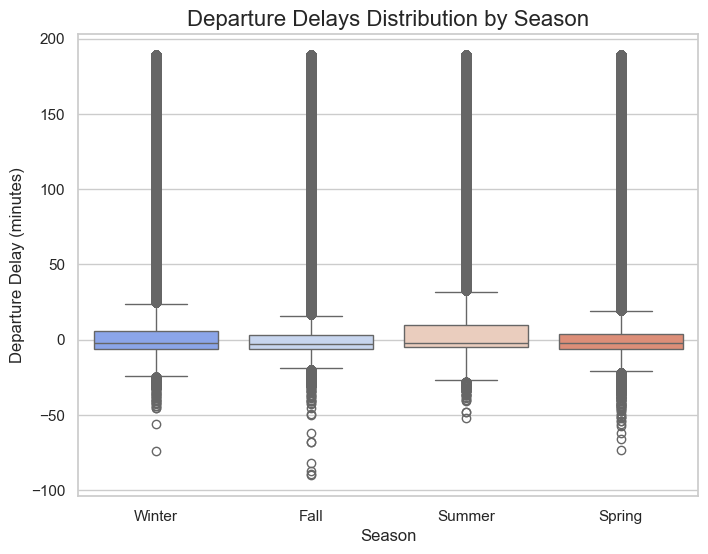

In [108]:
#---Departure Delays Distribution by Season---

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Season', y='DEP_DELAY', palette="coolwarm")
plt.title("Departure Delays Distribution by Season", fontsize=16)
plt.ylabel("Departure Delay (minutes)")
plt.show()


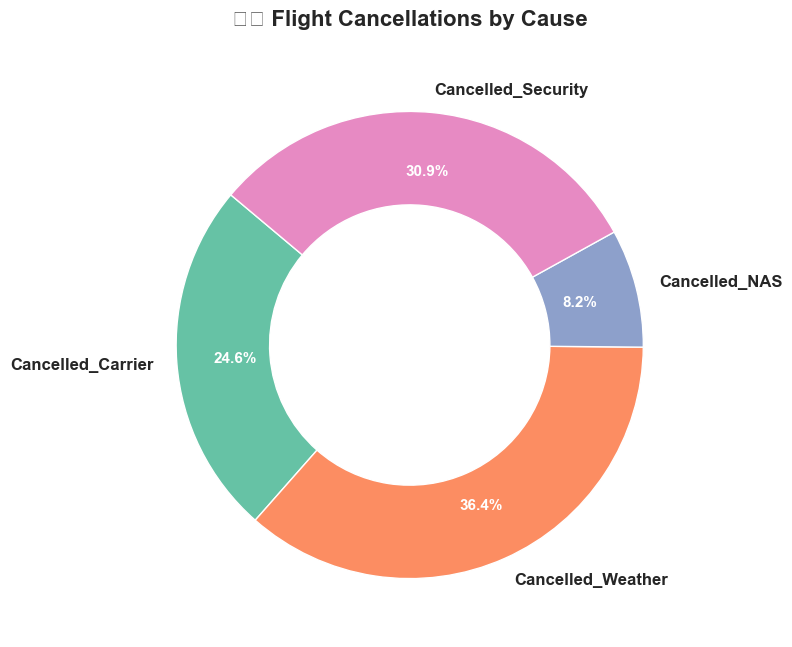

In [109]:
#---Flight Cancellations by Cause---


# Define cancellation columns
cancel_cols = ['Cancelled_Carrier', 'Cancelled_Weather', 'Cancelled_NAS', 'Cancelled_Security']

# Aggregate counts
cancel_counts = df[cancel_cols].sum()

# Colors for clarity
colors = plt.cm.Set2.colors  

# Plot Donut Chart
plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    cancel_counts,
    labels=cancel_counts.index,
    autopct='%1.1f%%',
    pctdistance=0.75,  # moves percentage labels inside the donut
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='white')
)

# Style labels and percentages
plt.setp(texts, size=12, weight="bold")
plt.setp(autotexts, size=11, weight="bold", color="white")

# Add center circle for donut effect
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Title
plt.title("✈️ Flight Cancellations by Cause", fontsize=16, weight="bold", pad=20)

plt.tight_layout()
plt.show()


### Flight Cancellations by Reason (2019–2023)

- **Weather** is the **highest cause** of cancellations → flights are most affected by storms, fog, and extreme conditions.  
- **Security** is the **second highest cause** → unusual spike during **2020 (COVID-19 period)** due to travel bans and heightened airport checks.  
- **Carrier-related issues** are the **third highest cause** → cancellations due to airline operational or technical problems.  
- **NAS (Air Traffic System)** is the **least cause** → very few cancellations due to air traffic control restrictions.  

**Key Insight:**  
> **Weather and Security (external factors) dominate cancellations**, while **Carrier and NAS (airline/operational factors)** contribute relatively less.


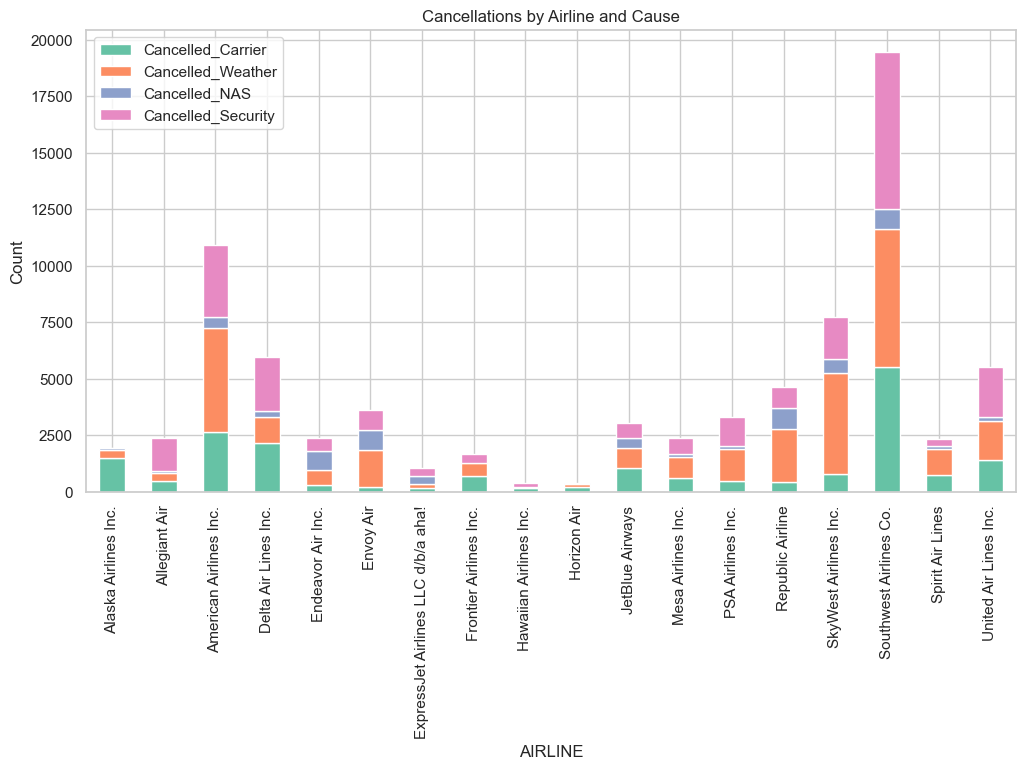

In [111]:
#--- Delay Causes by Airline (Carrier, Weather, NAS, Security)---
delay_causes = df.groupby("AIRLINE")[['Cancelled_Carrier','Cancelled_Weather','Cancelled_NAS','Cancelled_Security']].sum()
delay_causes.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Cancellations by Airline and Cause")
plt.ylabel("Count")
plt.show()

In [112]:
# Filter for security cancellations
security_cancellations = df[df['Cancelled_Security'] == 1]

# Extract year
security_cancellations['Year'] = security_cancellations['FL_DATE'].dt.year

# Count cancellations per year
security_by_year = security_cancellations.groupby('Year')['Cancelled_Security'].sum()

print(security_by_year)

Year
2020    24221
2021       68
2022      101
2023       27
Name: Cancelled_Security, dtype: int64


### Security Cancellations (2019–2023)

**2020** saw a huge spike (**24,221**) due to **_COVID-19 restrictions and heightened airport protocols_**.  
Numbers dropped sharply in **2021–2023** (**68, 101, 27**), returning to minimal levels.  

> **_COVID-19_** was the main driver of unusually high security cancellations, with normal patterns resuming afterward.
